In [1]:
%load_ext autoreload
%autoreload 2

import astropy
import galsim
import matplotlib.pyplot as plt
import numpy as np
import scarlet
import sep

import btk
import galcheat.utilities


# SCARLET implementation

This notebook provides a measure function using [SCARLET](https://www.sciencedirect.com/science/article/abs/pii/S2213133718300301), a deblending algorithm based on matrix factorization. **NOTE:** It requires that you install the scarlet python package from the [source](https://github.com/pmelchior/scarlet), the pip installation being outdated. Please follow the instructions for installing scarlet [here](https://pmelchior.github.io/scarlet/install.html). 

If you have not done so already, we encourage you to follow the BTK [intro tutorial](https://lsstdesc.org/BlendingToolKit/tutorials.html), which will help you understand what is done in this notebook.

In [2]:
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
surveys = btk.survey.get_surveys(["LSST","HSC"])

In [3]:
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    btk.sampling_functions.DefaultSampling(max_number=5,maxshift=6),
    surveys,
    stamp_size=stamp_size,
    batch_size=10
)

In [76]:
def scarlet_measure(batch,idx,channels_last=False,**kwargs):
    """Measure function for SCARLET
    """
    sigma_noise = kwargs.get("sigma_noise", 1.5)    
    surveys = kwargs.get("surveys", None)
    filters = [surveys[0].get_filter(b) for b in surveys[0].available_filters]
    channel_indx = 0 if not channels_last else -1
    
    #Fist we carry out the detection, using SExtractor (sep being the python implementation)
    # We need to differentiate between the multiresolution and the regular case
    if isinstance(batch["blend_images"], dict):
        survey_name = surveys[0].name
        image = batch["blend_images"][survey_name][idx]
        coadd = np.mean(image, axis=channel_indx)
        wcs_ref = batch["wcs"][survey_name]
        psf = np.array([p.drawImage(galsim.Image(image.shape[1],image.shape[2]),scale=surveys[0].pixel_scale.to_value("arcsec")).array for p in batch["psf"][survey_name]])
        multiresolution = True
    else:
        image = batch["blend_images"][idx]
        coadd = np.mean(image, axis=channel_indx)
        psf = np.array([p.drawImage(galsim.Image(image.shape[1],image.shape[2]),scale=surveys[0].pixel_scale.to_value("arcsec")).array for p in batch["psf"]])
        wcs_ref = batch["wcs"]
        multiresolution = False
    stamp_size = coadd.shape[0]
    
    bkg = sep.Background(coadd)
    catalog, segmentation = sep.extract(
        coadd, sigma_noise, err=bkg.globalrms, segmentation_map=True
    )

    
    if len(catalog) == 0:
        t = astropy.table.Table()
        t["ra"], t["dec"] = wcs_ref.pixel_to_world_values(catalog["x"], catalog["y"])
        t["ra"], t["dec"] = t["ra"]*3600,t["dec"]*3600
        if multiresolution:
            return {"catalog":t,"segmentation":None,"deblended_images":{s.name: np.array([np.zeros((len(s.available_filters),batch["blend_images"][s.name][idx].shape[1],
                                                batch["blend_images"][s.name][idx].shape[1]))]) for s in surveys}}
        else:
            s = surveys[0]
            return {"catalog":t,"segmentation":None,"deblended_images":np.array([np.zeros((len(s.available_filters),batch["blend_images"][idx].shape[1],
                                                batch["blend_images"][idx].shape[1]))])}
    
    mean_sky_level = [galcheat.utilities.mean_sky_level(surveys[0],filt) for filt in filters]

    
    ### Initializing scarlet ###
    bands = surveys[0].available_filters
    model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(bands))
    
    # The observation contains the blended images as well as additionnal informations
    observations = [scarlet.Observation(
        image, psf=scarlet.ImagePSF(psf), weights=np.ones(image.shape)/ (bkg.globalrms**2), channels=bands, wcs=wcs_ref
    )]
    
    # We define an observation for each survey
    for survey in surveys[1:]:
        image = batch["blend_images"][survey.name][idx]
        image = np.moveaxis(image,-1,0) if channels_last else image
        psf = np.array([p.drawImage(galsim.Image(image.shape[1],image.shape[2]),scale=survey.pixel_scale.to_value("arcsec")).array for p in batch["psf"][survey.name]])
        bands=survey.available_filters
        coadd = np.mean(image, axis=0)
        bkg = sep.Background(coadd)
        wcs = batch["wcs"][survey.name]
        observations.append(scarlet.Observation(
            image, psf=scarlet.ImagePSF(psf), weights=np.ones(image.shape)/ (bkg.globalrms**2), channels=bands, wcs=wcs
        ))
    
    # We create a frame grouping all the observations
    model_frame = scarlet.Frame.from_observations(observations, coverage='intersection', model_psf=model_psf)
    
    # We define a source for each detection
    sources = []
    for n, detection in enumerate(catalog):
        result = scarlet.ExtendedSource(
            model_frame,
            model_frame.get_sky_coord((detection["y"], detection["x"])),
            observations,
            thresh=1,
            shifting=True,
        )
        sources.append(result)
    scarlet.initialization.set_spectra_to_match(sources, observations)
    
    ### Fitting the sources to the blend ###
    try:
        blend = scarlet.Blend(sources, observations)
        blend.fit(200, e_rel=1e-5)
 
        ### Returning the results in a BTK compatible form ###
        deblended_images = {}
        for i in range(len(surveys)):
            im, selected_peaks = [], []
            for k, component in enumerate(sources):
                y, x = component.center
                selected_peaks.append([x, y])
                model = component.get_model(frame=model_frame)
                model_ = observations[i].render(model)
                model_ = np.transpose(model_, axes=(1, 2, 0)) if channels_last else model_
                im.append(model_)
            selected_peaks = np.array(selected_peaks)
            deblended_images[surveys[i].name] = np.array(im)
        t = astropy.table.Table()
        t["ra"], t["dec"] = wcs_ref.pixel_to_world_values(selected_peaks[:,0], selected_peaks[:,1])
        
    except AssertionError: # If the fitting fails, return empty images
        t = astropy.table.Table()
        t["ra"], t["dec"] = wcs_ref.pixel_to_world_values(catalog["x"], catalog["y"])
        if multiresolution:
            deblended_images={s.name: np.array([np.zeros((len(s.filters),batch["blend_images"][s.name][idx].shape[1],
                                              batch["blend_images"][s.name][idx].shape[1])) for c in catalog]) for s in surveys}
        else:
            deblended_images={s.name: np.array([np.zeros((len(s.filters),batch["blend_images"][idx].shape[1],
                                              batch["blend_images"][idx].shape[1])) for c in catalog]) for s in surveys}
        print("failed")
    
    if len(surveys) == 1:
        deblended_images = deblended_images[surveys[0].name]
    t["ra"], t["dec"] = t["ra"]*3600,t["dec"]*3600
    return {"catalog":t,"segmentation":None,"deblended_images":deblended_images}

In [77]:
measure_kwargs=[{"sigma_noise": 2.0}]
meas_generator = btk.measure.MeasureGenerator(
    [btk.measure.sep_measure,scarlet_measure], draw_blend_generator, measure_kwargs=measure_kwargs
)
metrics_generator = btk.metrics.MetricsGenerator(
    meas_generator,
    target_meas={"ellipticity": btk.metrics.meas_ksb_ellipticity},
    meas_band_name=('r', 'r')
)

In [78]:
blend_results,measure_results,metrics_results = next(metrics_generator)

Generating blends for LSST survey:   0%|          | 0/10 [00:00<?, ?it/s]

Generating blends for HSC survey:   0%|          | 0/10 [00:00<?, ?it/s]

/home/thuiop/Documents/stageAPC/BlendingToolKit/env/lib64/python3.9/site-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


# Plot Metrics from Scarlet Results

In [79]:
btk.plot_utils.plot_metrics_summary(metrics_results,interactive=True)

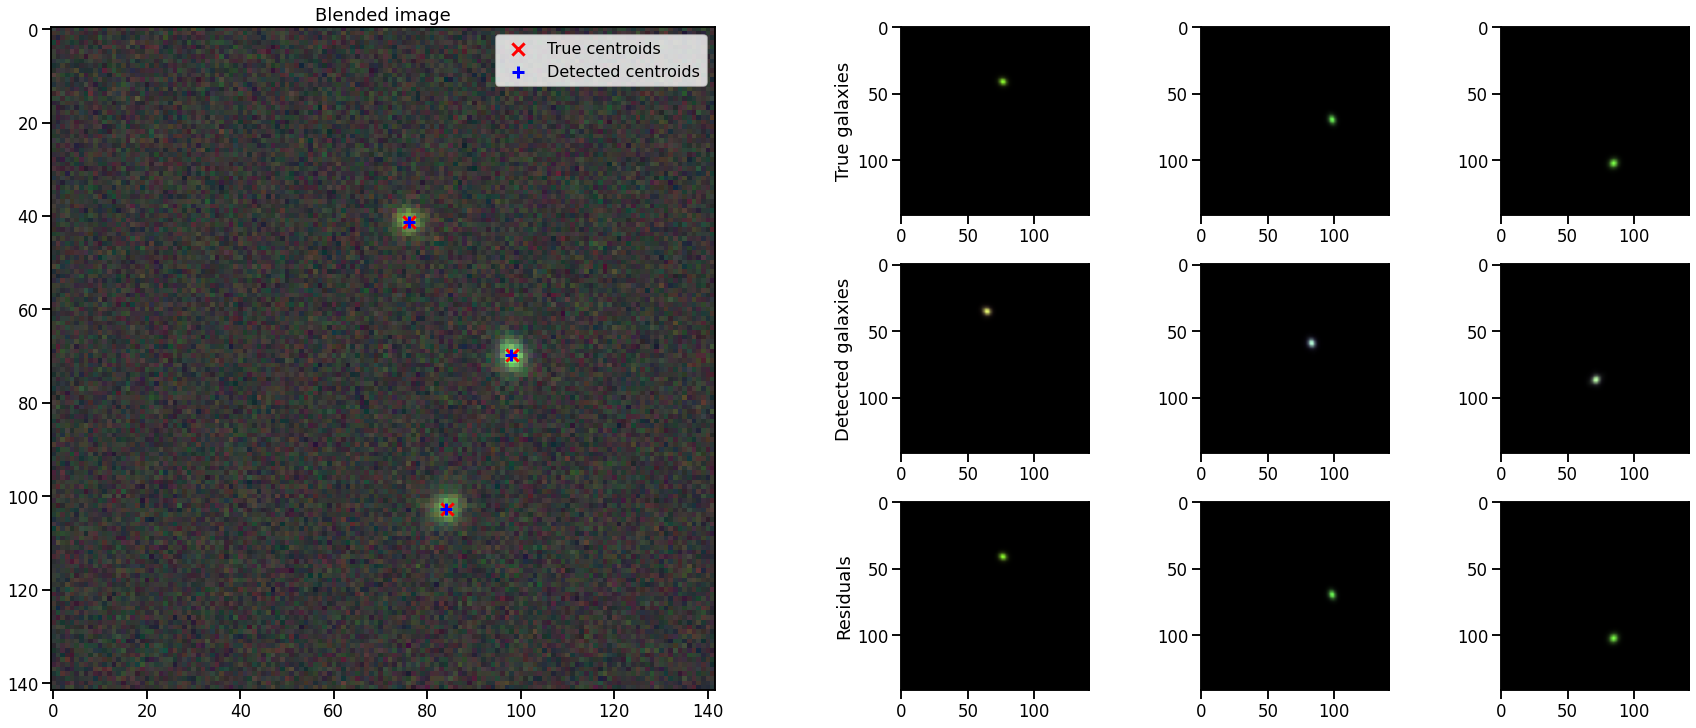

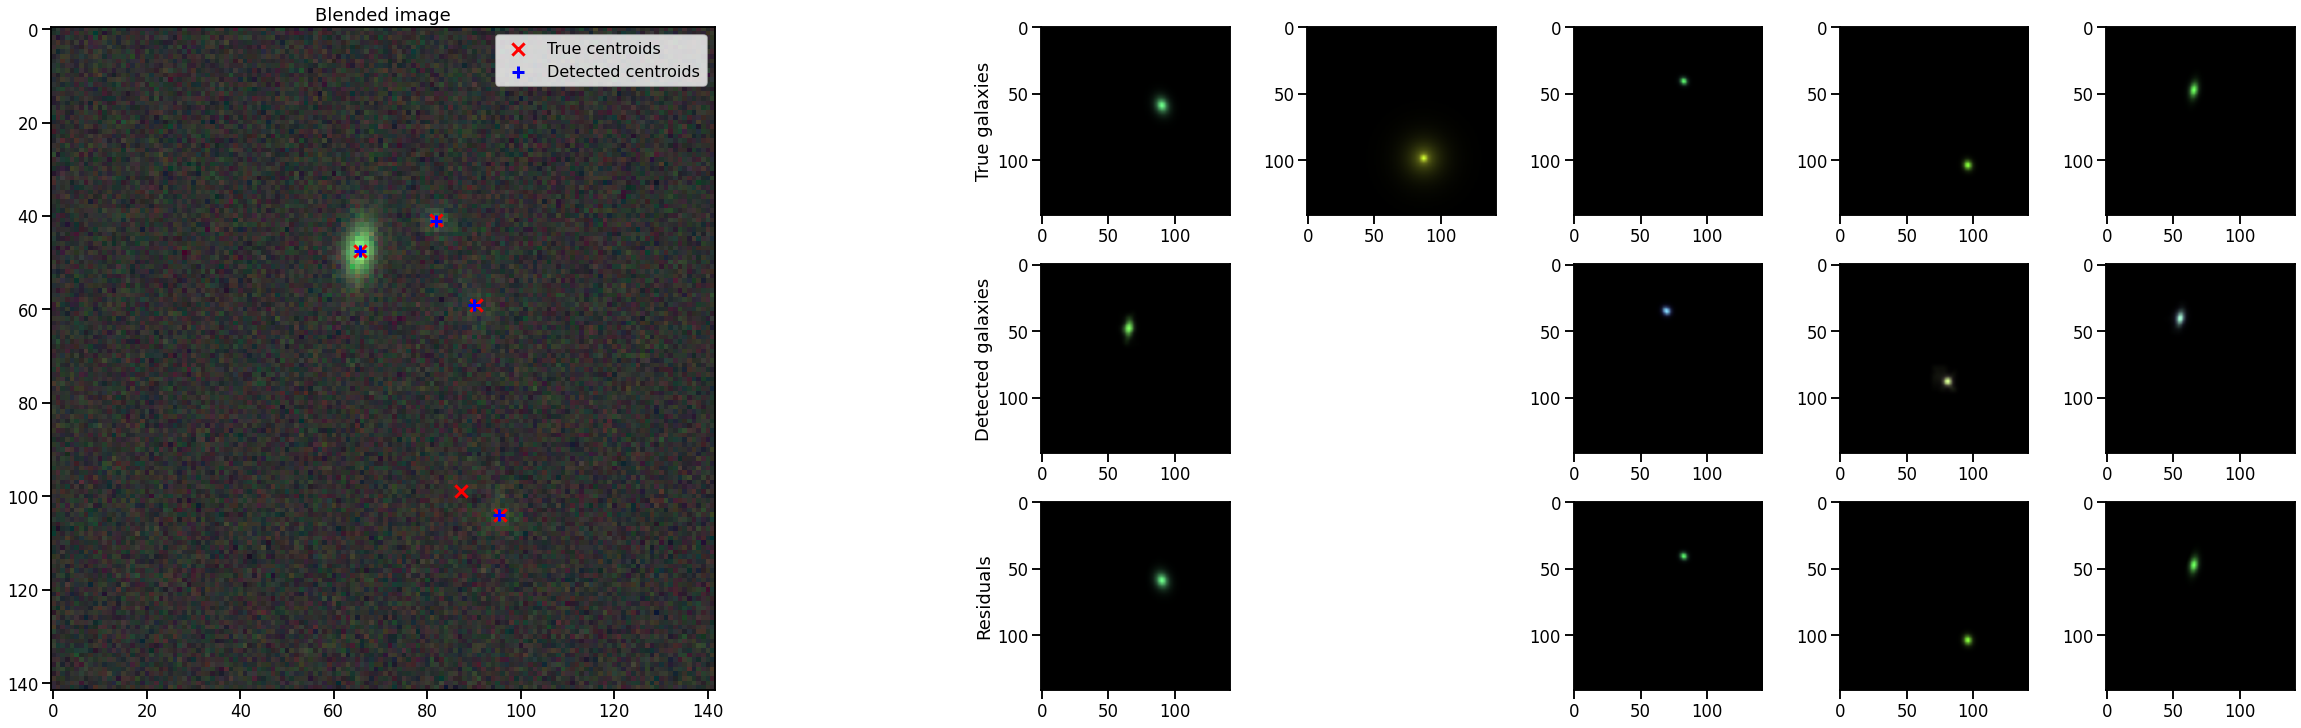

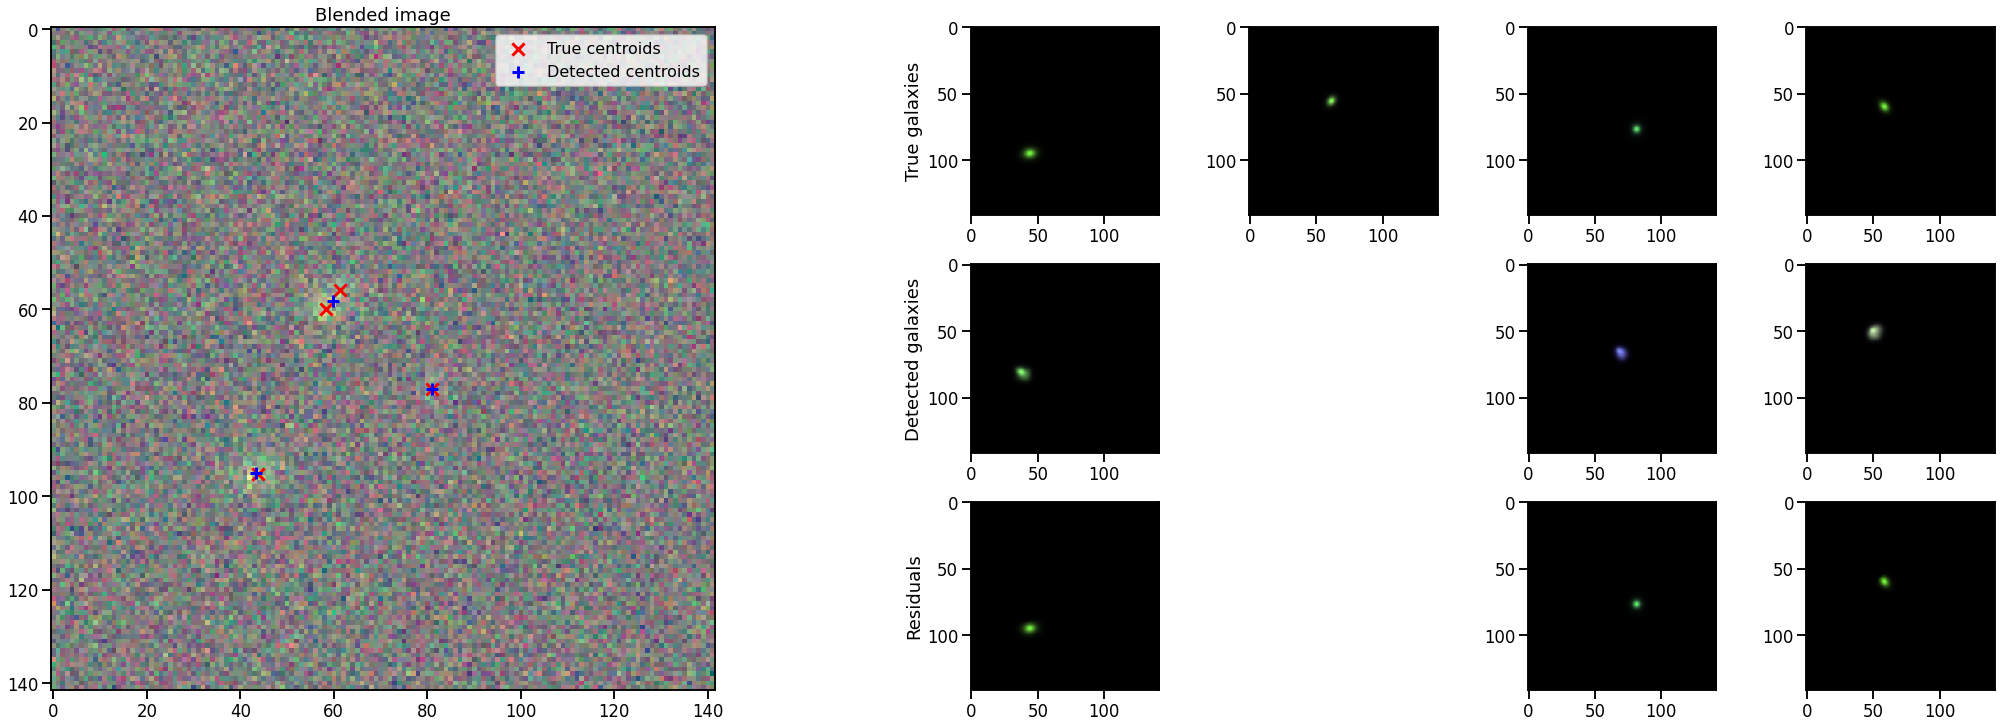

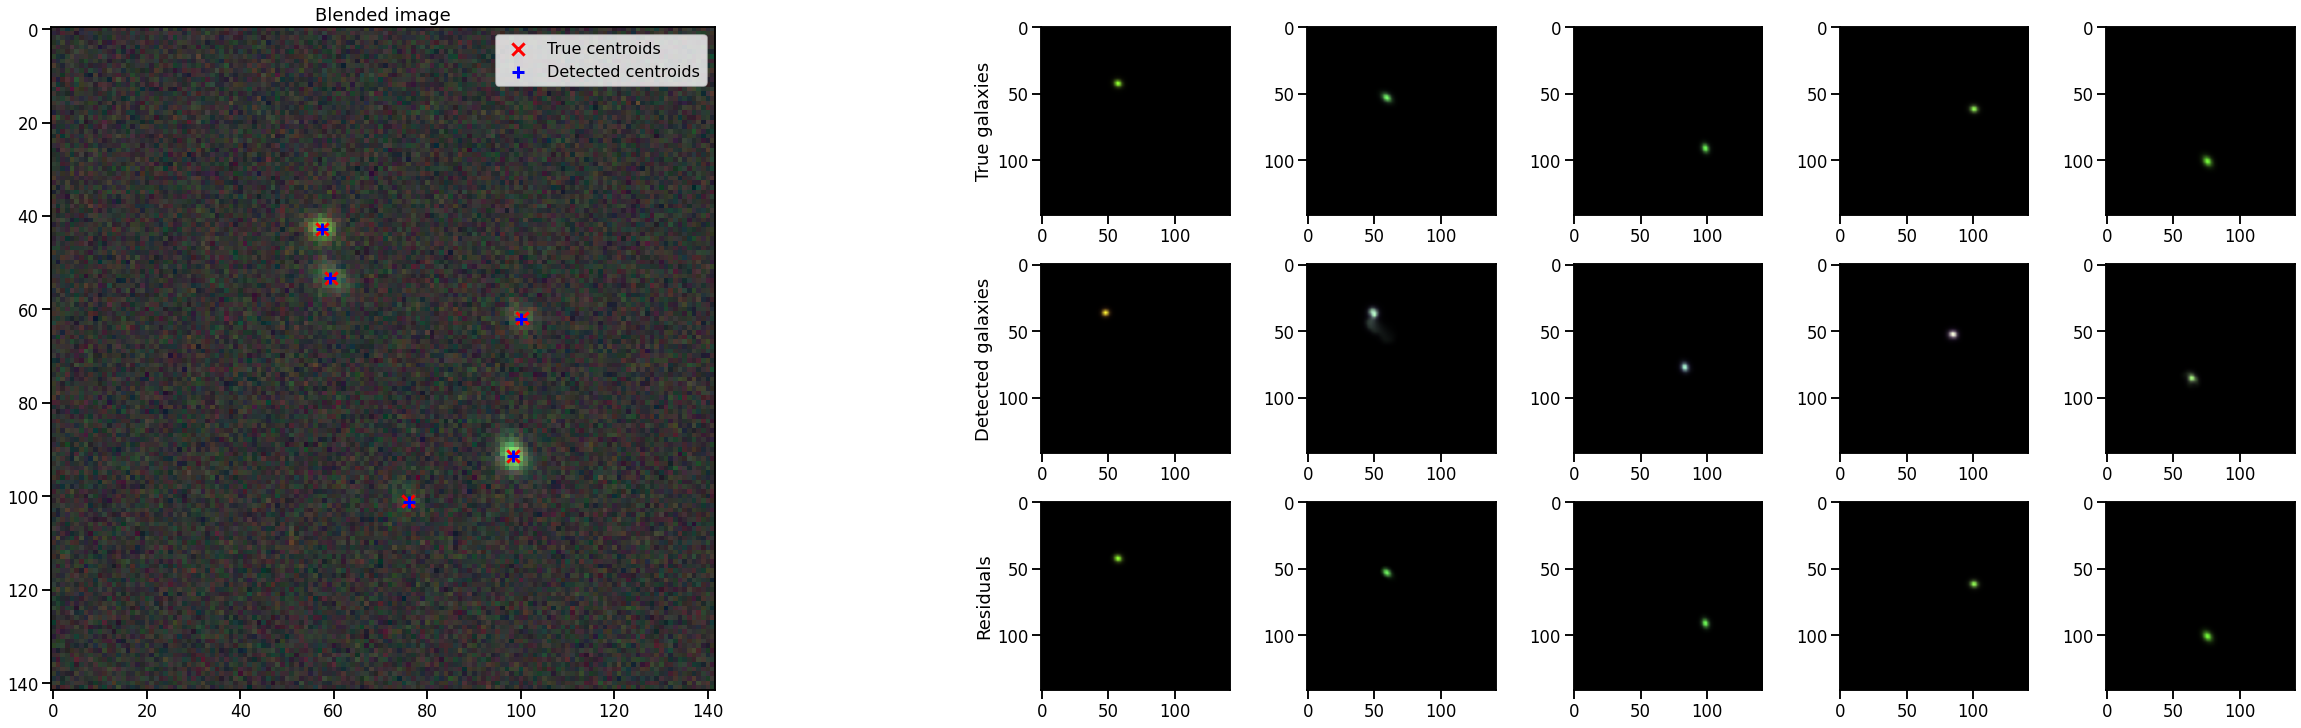

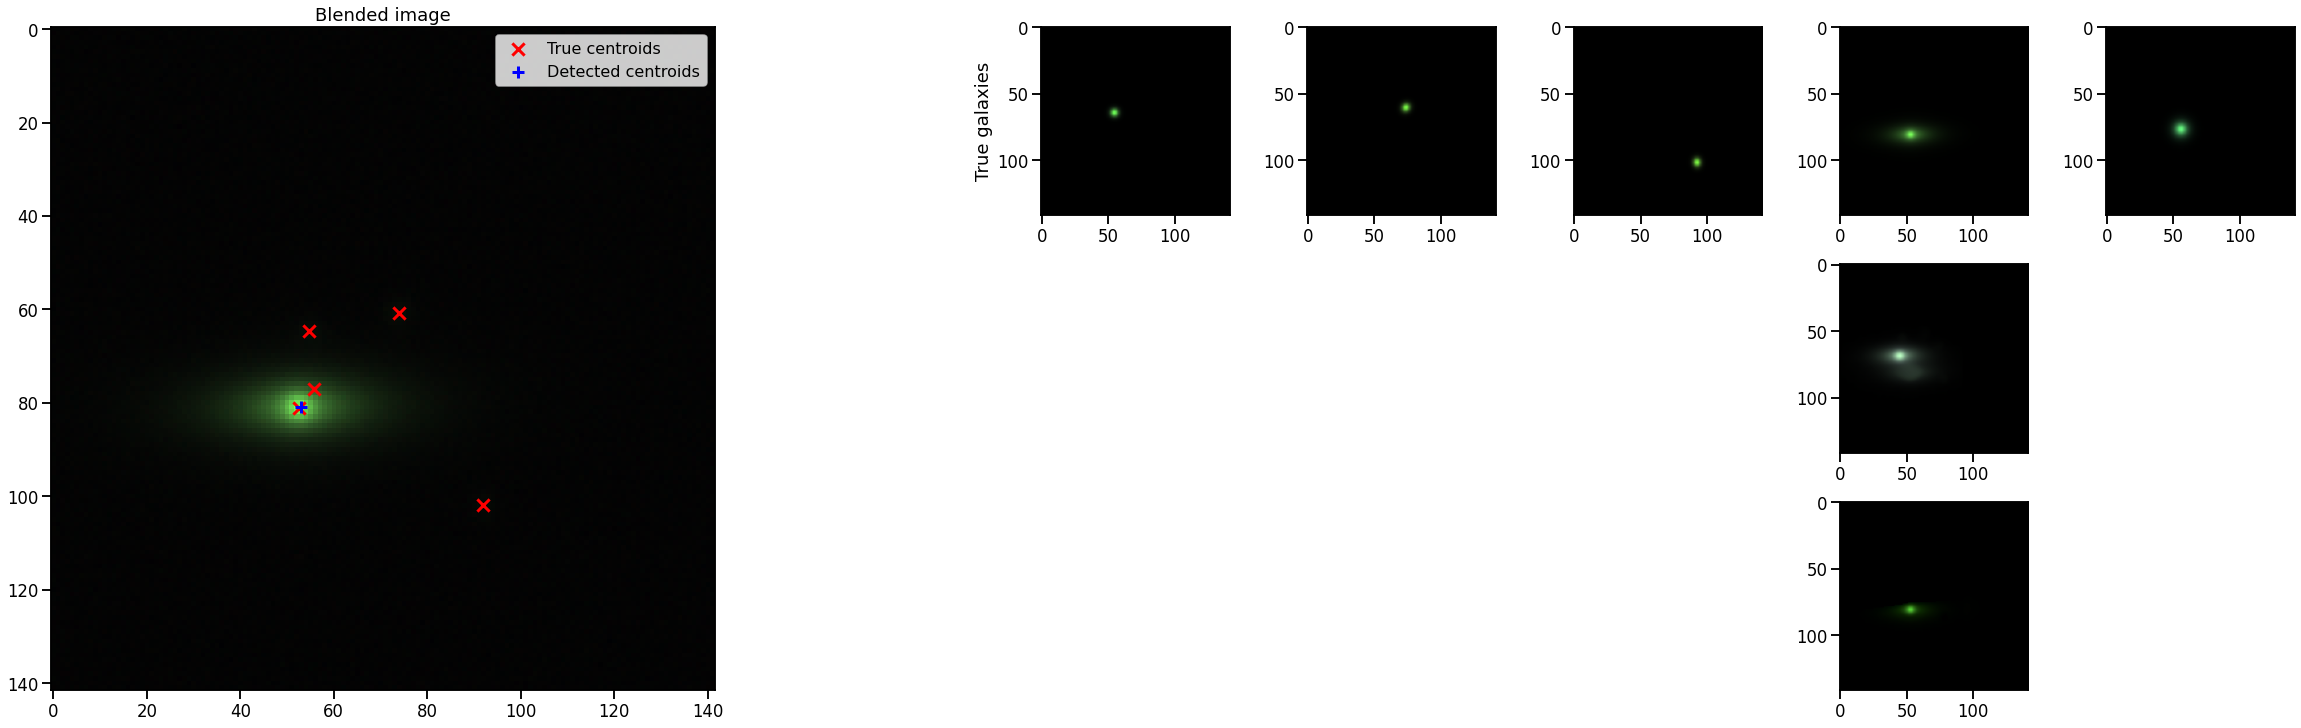

In [80]:
survey = "HSC"
btk.plot_utils.plot_with_deblended(
    blend_results["blend_images"][survey],
    blend_results["isolated_images"][survey],
    blend_results["blend_list"][survey],
    measure_results["catalog"]["scarlet_measure"][survey],
    measure_results["deblended_images"]["scarlet_measure"][survey],
    metrics_results["matches"]["scarlet_measure"][survey],
    indexes=list(range(5)),
    band_indices=[1, 2, 3]
)

TypeError: 'NoneType' object is not subscriptable

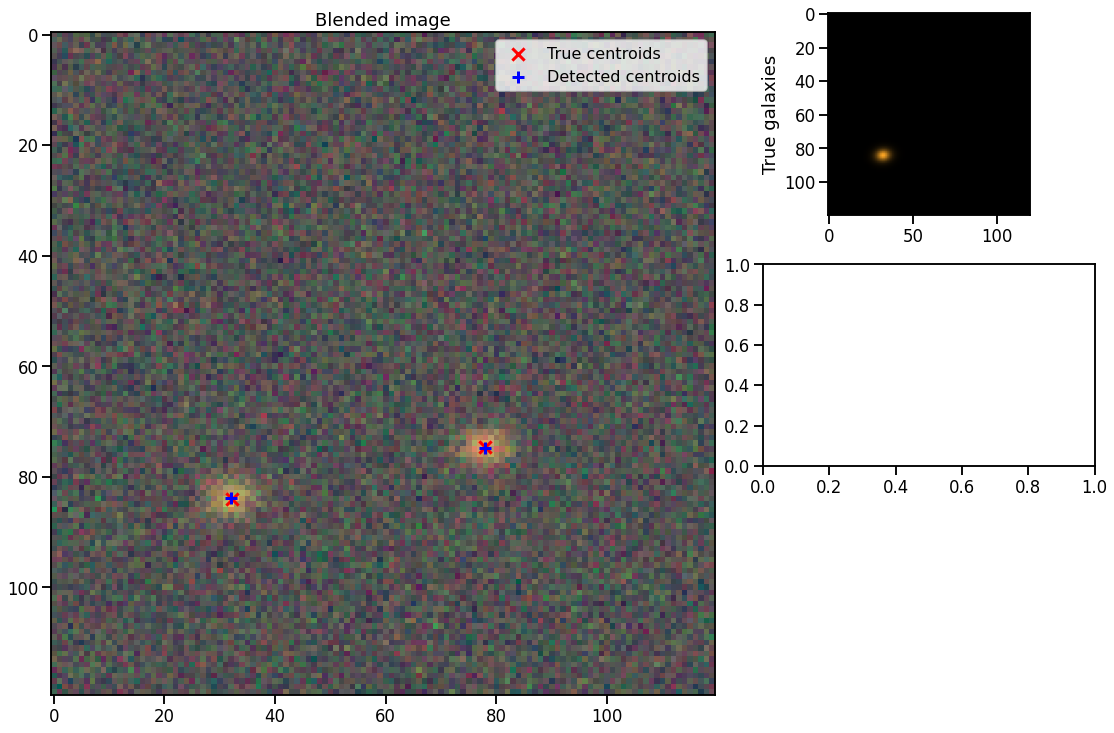

In [48]:
survey = "LSST"
btk.plot_utils.plot_with_deblended(
    blend_results["blend_images"][survey],
    blend_results["isolated_images"][survey],
    blend_results["blend_list"][survey],
    measure_results["catalog"]["sep_measure"][survey],
    measure_results["deblended_images"]["sep_measure"][survey],
    metrics_results["matches"]["sep_measure"][survey],
    indexes=list(range(5)),
    band_indices=[1, 2, 3]
)